In [2]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [3]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


Librerias a Utilizar

In [4]:

import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt
import os
import warnings
from tcn import TCN
import math as m
from tensorflow.keras import layers
from tensorflow.keras.layers import Concatenate, Input, LSTM, Dense
from tensorflow.keras.models import Model

Lectura de Dataset preprocesado

In [152]:
arch='MILSTM'
project_path='/content/drive/MyDrive/Price_Prediction'

df=pd.read_csv(project_path+'/DataCompleta_Resultados/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [155]:
# Lista de fechas a eliminar
fechas_a_eliminar = ['2015-03-26', '2015-07-08', '2015-10-12', '2015-12-17']

# Eliminar las filas con las fechas especificadas
df = df[~df['Date'].isin(fechas_a_eliminar)]

# Mostrar el DataFrame resultante
df


,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


Se utiliza solo un segmento del DataSet para pruebas

In [171]:
dfCorto = df.head(804)
dfCorto

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,2015-07-17,AMZN,0.764742,23.885000,24.271000,23.862499,24.150499,98644000,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565
810,2015-07-17,GOOG,0.854523,32.450001,33.723400,32.250000,33.646500,223298000,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565
811,2015-07-17,GOOGL,0.821173,34.000000,35.150002,33.900002,34.980999,257162000,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565
812,2015-07-17,MSFT,0.820405,46.549999,46.779999,46.259998,46.619999,29467100,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565


In [172]:
a=dfCorto['ticker_symbol']=='AAPL'
a.sum()

134

In [173]:
b=dfCorto['ticker_symbol']=='AMZN'
b.sum()

134

In [174]:
c=dfCorto['ticker_symbol']=='GOOG'
c.sum()

134

In [175]:
d=dfCorto['ticker_symbol']=='GOOGL'
d.sum()

134

In [176]:
e=dfCorto['ticker_symbol']=='MSFT'
e.sum()

134

In [178]:
f=dfCorto['ticker_symbol']=='TSLA'
f.sum()

134

Separacion de Empresas en diccionario

In [222]:
metric_labels=['Testing-MSE','Validation-MSE','testing-MAE','validation-MAE','testing-mape','validation-mape','testing-RMSE','validation-RMSE', 'testing-MPE','validation-MPE']
metrics_df=pd.DataFrame()
metrics_df['Metrics']=metric_labels
std_metrics_df=pd.DataFrame()
std_metrics_df['Metrics']=metric_labels

mse_t_p=[]
mae_t_p=[]
mape_t_p=[]
rmse_t_p=[]
mpe_t_p=[]
mse_v_p=[]
mae_v_p=[]
mape_v_p=[]
rmse_v_p=[]
mpe_v_p=[]


overall_mse_train=[]
overall_mse_val=[]
overall_std_train=[]
overall_std_val=[]

#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metrics.csv',index=False)
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metrics.csv',index=False)
df_dict={}

for key in dfCorto['ticker_symbol'].unique():
    df_dict[key]=dfCorto[dfCorto['ticker_symbol']==key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)

df_dict

{'AAPL':            Date  p_sentiment       Open       High        Low      Close  \
 0    2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
 1    2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
 2    2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
 3    2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
 4    2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
 ..          ...          ...        ...        ...        ...        ...   
 129  2015-07-13     0.742417  31.257500  31.440001  31.080000  31.415001   
 130  2015-07-14     0.777421  31.510000  31.592501  31.260000  31.402500   
 131  2015-07-15     0.787304  31.430000  31.787500  31.395000  31.705000   
 132  2015-07-16     0.770357  31.934999  32.142502  31.837500  32.127499   
 133  2015-07-17     0.781360  32.270000  32.404999  32.077499  32.404999   
 
         Volume  unrate  psr       m2    dspic      pce    reer   

Creacion de las secuencias de entrada y salida de cada empresa (ventana de tiempo)

In [229]:
tf.keras.utils.set_random_seed(42)
# Lista para almacenar los datos de entrada para cada canal
X_channels, y_channels = [], []

keys=df_dict.keys()
#to list
keys_list=list(keys)

# Preprocesamiento de datos y almacenamiento en las listas X_channels y y_channels
for ticker_symbol in keys_list:
    df = df_dict[ticker_symbol].copy()
    df = df[['p_sentiment', 'Open', 'High', 'Low', 'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro', 'ccpi', 'Close']]
    cols = list(df)

    # Escalado de datos
    #Valores entre 0 y 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.astype(float))

    n_future = 1
    n_past = 7

    # División de datos en entrada y salida para cada canal
    X_ticker = []
    y_ticker = []
    for i in range(n_past, len(scaled_data) - n_future + 1):
        X_ticker.append(scaled_data[i - n_past:i, :])
        y_ticker.append(scaled_data[i + n_future - 1:i + n_future, -1])

    X_channels.append(X_ticker)
    y_channels.append(y_ticker)

#Secuencias de cada Empresa
# Convertir listas a arrays numpy
X_channels = [np.array(X_ticker) for X_ticker in X_channels]
y_channels = [np.array(y_ticker) for y_ticker in y_channels]

In [230]:
len(X_channels)

6

In [234]:
len(y_channels)

6

In [225]:
pd.DataFrame(X_channels[0][0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.695428,0.173711,0.147916,0.101606,0.228850,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.123658
1,0.989754,0.062679,0.045002,0.029137,0.320464,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.009626
2,0.500501,0.000000,0.000000,0.000000,0.332961,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.009997
3,0.616225,0.023639,0.028403,0.077325,0.120554,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.065161
4,0.708747,0.096347,0.174106,0.152036,0.279778,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.218438
5,0.723998,0.219556,0.214681,0.208442,0.232942,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.222881
6,1.000000,0.217049,0.191811,0.155772,0.199468,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.210341,0.0,1.0,0.0,0.120696


Funcion que contiene implementacion del modelo MILSTM

In [473]:
# def build_model(hp):
#     hp_units = hp.Int('units', min_value=2, max_value=240, step=2)
#     #num_lstm_layers = len(keys_list)

#     model = Sequential()

#     # Añadir capas LSTM segun el tamaño de X_channels
#     for channel_X in X_channels:
#       print('channel_X.shape[1] ',channel_X.shape[1])
#       print('channel_X.shape[2] ',channel_X.shape[2])
#       model.add(LSTM(units=hp_units, input_shape=(channel_X.shape[1], channel_X.shape[2]), return_sequences=True))
#       print('Capa Añadida!')
#       print(model)

#     # Concatenar las salidas de las capas LSTM
#     model.add(Concatenate(axis=1))

#     # Añadir capas densas adicionales para cada salida
#     for channel_y in y_channels:
#       model.add(Dense(channel_y.shape[1]))  # Las unidades se ajustan a la forma de la entrada

#     # Compilar el modelo
#     model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='mse')

#     return model


def build_model(hp):
    hp_units = hp.Int('units', min_value=2, max_value=240, step=2)
    num_output_layers = len(y_channels)

    # Definir las entradas para cada canal
    inputs = []
    for channel_X in X_channels:
        input_i = Input(shape=(channel_X.shape[1], channel_X.shape[2]))
        inputs.append(input_i)

    # Procesamiento de cada canal de entrada
    processed_outputs = []
    for input_i in inputs:
        # Agregar capas LSTM para cada canal de entrada
        processed_output_i = LSTM(units=hp_units, return_sequences=True)(input_i)
        processed_outputs.append(processed_output_i)

    # Concatenar las salidas de procesamiento
    concatenated_output = Concatenate(axis=1)(processed_outputs)
    processed_final=[]
    for output_i in outputs:
        output_i = Dense(units=y_channels[0].shape[1])(processed_outputs)
        outputs.append(output_i)
    print('in',inputs,'out', outputs)
    # Modelo completo
    model = Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='mse')

    return model


In [474]:
# Instanciar el callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Definir el project_name incluyendo tanto el ticker como el canal de cada entrada
ticker = [f'{i}' for i in range(len(X_channels))]

# Instanciar el optimizador de hiperparámetros Kerastuner
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     #max_trials=15,
                     directory=project_path + f'/Models/{arch}_Tuning',
                     project_name=''.join(ticker) + f'_{arch}_tuning')

# Buscar los mejores hiperparámetros para el modelo
tuner.search(X_channels, y_channels, epochs=1000, validation_split=0.2, callbacks=[early_stop])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true,y_pred))
def mpe(y_true, y_pred):
    return np.mean((y_pred - y_true) / y_true) * 100

early_stop=EarlyStopping(monitor='val_loss',patience=20)
dir=project_path+f'/Graphs/{arch}_'+''.join(ticker)
tscv = TimeSeriesSplit(n_splits=10)

# Cálculo de métricas para cada canal de entrada y salida
t_mses = []
v_mses = []
t_maes = []
v_maes = []
t_mapes = []
v_mapes = []
t_rmses = []
v_rmses = []
t_mpes = []
v_mpes = []

counter_fold=1

#val_losses = []
#train_losses = []
metrics=[]

x_train, x_val = [], []
y_train, y_val = [], []

for channel_index in range(len(X_channels)):
  X_channel = X_channels[channel_index]
  y_channel = y_channels[channel_index]

  Fold = 'Fold_' + str(counter_fold)
  counter_fold += 1

  print(f'{Fold} Started...')
  # Crear directorio para cada fold si no existe
  if not os.path.exists(os.path.join(dir, Fold)):
      os.makedirs(os.path.join(dir, Fold))
  X_train_channel, X_val_channel=[],[]
  y_train_channel, y_val_channel=[],[]
  # Dividir los datos en conjuntos de entrenamiento y validación
  for train_index, test_index in tscv.split(X_channel):
    # X_train_channel.append(X_channel[train_index])
    # X_val_channel.append(X_channel[test_index])
    # y_train_channel.append(y_channel[train_index])
    # y_val_channel.append(y_channel[test_index])
    #print('len',len(X_train_channel))
    X_tmp, X_test = X_channel[train_index], X_channel[test_index]
    y_tmp, y_test= y_channel[train_index], y_channel[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
  x_train.append(X_tmp[:val_split])
  x_val.append(X_tmp[val_split:])
  y_train.append(y_tmp[:val_split])
  y_val.append(y_tmp[val_split:])

  # Agregar los datos a las listas de entrenamiento y validación
  # x_train.append(X_train_channel)
  # x_val.append(X_val_channel)
  # y_train.append(y_train_channel)
  # y_val.append(y_val_channel)
  #print('channel_index',channel_index)


Reloading Tuner from /content/drive/MyDrive/Price_Prediction/Models/MILSTM_Tuning/012345_MILSTM_tuning/tuner0.json
Fold_1 Started...
Fold_2 Started...
Fold_3 Started...
Fold_4 Started...
Fold_5 Started...
Fold_6 Started...


In [475]:
# Construir el modelo
model=model = tuner.hypermodel.build(best_hps)

# Entrenar el modelo para cada canal
# for X_train_channel, y_train_channel, X_val_channel, y_val_channel in zip(x_train, y_train, x_val, y_val):
#   history=model.fit(X_train_channel, y_train_channel, epochs=10, validation_data=(X_val_channel, y_val_channel), shuffle=False, callbacks=[early_stop], verbose=False)

history=model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), shuffle=False, callbacks=[early_stop], verbose=False)

# Crear listas para almacenar las pérdidas de entrenamiento y validación por clas]


ValueError: Layer "dense_445" expects 1 input(s), but it received 6 input tensors. Inputs received: [<tf.Tensor 'Placeholder:0' shape=(None, 7, 30) dtype=float32>, <tf.Tensor 'Placeholder_1:0' shape=(None, 7, 30) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(None, 7, 30) dtype=float32>, <tf.Tensor 'Placeholder_3:0' shape=(None, 7, 30) dtype=float32>, <tf.Tensor 'Placeholder_4:0' shape=(None, 7, 30) dtype=float32>, <tf.Tensor 'Placeholder_5:0' shape=(None, 7, 30) dtype=float32>]

In [420]:
len(x_train[0]),len(x_train[1]),len(x_train[2]),len(x_train[3]),len(x_train[4]),len(x_train[5])

(92, 92, 92, 92, 92, 92)

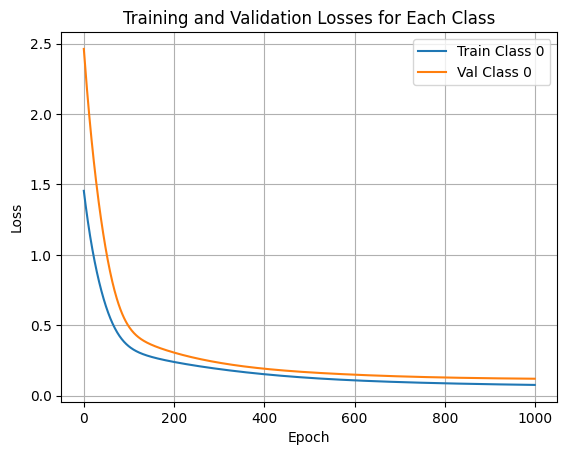

In [462]:
val_loss = []
train_loss = []

# Crear listas para almacenar las pérdidas de entrenamiento y validación por clase
num_classes = 1

for i in range(num_classes):
    # Obtener la pérdida de entrenamiento y validación para la clase actual
    train_loss.append(history.history['loss'])
    val_loss.append(history.history[f'val_loss'])

    # Graficar la pérdida de entrenamiento y validación para la clase actual
    plt.plot(train_loss[i], label=f'Train Class {i}')
    plt.plot(val_loss[i], label=f'Val Class {i}')

# Añadir etiquetas y leyenda
    plt.title('Training and Validation Losses for Each Class')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [443]:
# Imprimir los valores de pérdida de cada época y canal

for i in range(6):
  for epoch in range(10):  # asumiendo que hubo 10 épocas
    print(f'Epoch {epoch + 1}:')
    print(f'  Class {i}: Train Loss = {train_loss[i][epoch]}, Val Loss = {val_loss[i][epoch]}')


Epoch 1:
  Class 0: Train Loss = 1.4946998357772827, Val Loss = 2.612311840057373
Epoch 2:
  Class 0: Train Loss = 1.4739536046981812, Val Loss = 2.583169937133789
Epoch 3:
  Class 0: Train Loss = 1.4540730714797974, Val Loss = 2.5536911487579346
Epoch 4:
  Class 0: Train Loss = 1.434484601020813, Val Loss = 2.524324893951416
Epoch 5:
  Class 0: Train Loss = 1.4151883125305176, Val Loss = 2.4952151775360107
Epoch 6:
  Class 0: Train Loss = 1.396188497543335, Val Loss = 2.466420888900757
Epoch 7:
  Class 0: Train Loss = 1.377487063407898, Val Loss = 2.4379689693450928
Epoch 8:
  Class 0: Train Loss = 1.3590822219848633, Val Loss = 2.40986967086792
Epoch 9:
  Class 0: Train Loss = 1.3409712314605713, Val Loss = 2.38212513923645
Epoch 10:
  Class 0: Train Loss = 1.3231489658355713, Val Loss = 2.3547310829162598
Epoch 1:
  Class 1: Train Loss = 1.4946998357772827, Val Loss = 2.612311840057373
Epoch 2:
  Class 1: Train Loss = 1.4739536046981812, Val Loss = 2.583169937133789
Epoch 3:
  Class

train [1.4543817043304443, 1.4277533292770386, 1.4021936655044556, 1.3770660161972046, 1.352390170097351, 1.3281817436218262, 1.3044500350952148, 1.2811992168426514, 1.258428692817688, 1.2361353635787964, 1.2143136262893677, 1.192955493927002, 1.1720521450042725, 1.1515932083129883, 1.1315679550170898, 1.1119650602340698, 1.0927733182907104, 1.0739812850952148, 1.0555777549743652, 1.037551760673523, 1.0198928117752075, 1.0025907754898071, 0.9856358170509338, 0.9690185785293579, 0.9527305960655212, 0.9367632865905762, 0.9211089015007019, 0.905759871006012, 0.8907091617584229, 0.8759505152702332, 0.861477255821228, 0.8472837209701538, 0.8333642482757568, 0.8197137713432312, 0.806327223777771, 0.7931999564170837, 0.7803274989128113, 0.7677055597305298, 0.7553302645683289, 0.7431979179382324, 0.7313045859336853, 0.7196469306945801, 0.7082217931747437, 0.6970255374908447, 0.6860553622245789, 0.6753082275390625, 0.6647810935974121, 0.6544713377952576, 0.6443759799003601, 0.6344923377037048, 

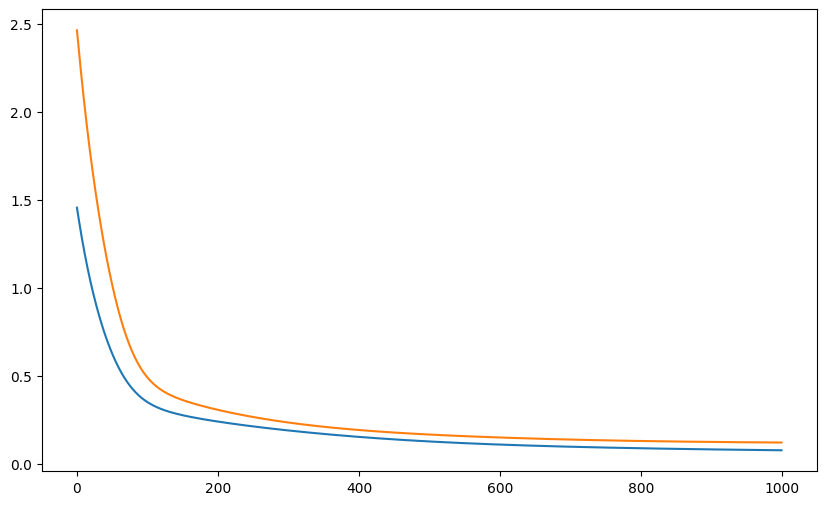

In [453]:
# import matplotlib.pyplot as plt

# # Crear una figura y ejes
# plt.figure(figsize=(10, 6))

# # Iterar sobre las épocas y canales y graficar los valores de pérdida
# for epoch in range(10):  # suponiendo que hay 10 épocas
#     for i in range(num_classes):
#         plt.plot(epoch + 1, train_loss[i][epoch], 'bo', label=f'Train Class {i}')  # 'bo' para puntos azules
#         plt.plot(epoch + 1, val_loss[i][epoch], 'ro', label=f'Val Class {i}')      # 'ro' para puntos rojos

# # Añadir etiquetas y leyenda
# plt.title('Training and Validation Losses for Each Epoch and Class')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# Crear un arreglo de épocas
epochs = np.arange(1, len(train_loss[0]) + 1)

# Crear una figura y ejes
plt.figure(figsize=(10, 6))

# Iterar sobre las clases y graficar los valores de pérdida
for i in range(num_classes):
    print('train',train_loss[i])
    print('val',val_loss[i])
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')


# Añadir etiquetas y leyenda
# plt.title('Training and Validation Losses for Each Class')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

  # plt.figure()
  # plt.plot(history.history['loss'],label='train')
  # plt.plot(history.history['val_loss'],label='val')
  # plt.legend()
  # plt.savefig(os.path.join(dir,Fold,'loss.png'))
  # plt.close()



In [ ]:
# Ajuste de y_test
y_test_concatenated = []
for y_test_channel in y_test:
  y_test_channel_concatenated = np.repeat(y_test_channel, X_channels[y_test_channel].shape[2], axis=1)
  y_test_channel_concatenated = scaler.inverse_transform(y_test_channel_concatenated)[:, -1]
  y_test_concatenated.append(y_test_channel_concatenated)

# Ajuste de y_val
y_val_concatenated = []
for y_val_channel in y_val:
  y_val_channel_concatenated = np.repeat(y_val_channel, X_channels[y_val_channel].shape[2], axis=1)
  y_val_channel_concatenated = scaler.inverse_transform(y_val_channel_concatenated)[:, -1]
  y_val_concatenated.append(y_val_channel_concatenated)

# Predicción para y_val
y_val_pred_concatenated = []
for x_val_channel in x_val:
  y_val_pred_channel = model.predict(x_val_channel, verbose=False)
  y_val_pred_channel_concatenated = np.repeat(y_val_pred_channel, X_channels[x_val_channel].shape[2], axis=1)
  y_val_pred_channel_concatenated = scaler.inverse_transform(y_val_pred_channel_concatenated)[:, -1]
  y_val_pred_concatenated.append(y_val_pred_channel_concatenated)

# Predicción para y_test
y_pred_concatenated = []
for X_test_channel in X_test:
  y_pred_channel = model.predict(X_test_channel, verbose=False)
  pred_channel_concatenated = np.repeat(y_pred_channel, X_train[X_test_channel].shape[2], axis=1)
  pred_channel_concatenated = scaler.inverse_transform(pred_channel_concatenated)[:, -1]
  y_pred_concatenated.append(pred_channel_concatenated)


for i in range(len(y_test_concatenated)):
  t_mse = mse(y_pred_concatenated[i], y_test_concatenated[i])
  t_mses.append(t_mse)
  v_mse = mse(y_val_pred_concatenated[i], y_val_concatenated[i])
  v_mses.append(v_mse)

  t_mae = mae(y_pred_concatenated[i], y_test_concatenated[i])
  t_maes.append(t_mae)
  v_mae = mae(y_val_pred_concatenated[i], y_val_concatenated[i])
  v_maes.append(v_mae)

  t_mape = mape(y_pred_concatenated[i], y_test_concatenated[i])
  t_mapes.append(t_mape)
  v_mape = mape(y_val_pred_concatenated[i], y_val_concatenated[i])
  v_mapes.append(v_mape)

  t_rmse = rmse(y_pred_concatenated[i], y_test_concatenated[i])
  t_rmses.append(t_rmse)
  v_rmse = rmse(y_val_pred_concatenated[i], y_val_concatenated[i])
  v_rmses.append(v_rmse)

  t_mpe = mpe(y_pred_concatenated[i], y_test_concatenated[i])
  t_mpes.append(t_mpe)
  v_mpe = mpe(y_val_pred_concatenated[i], y_val_concatenated[i])
  v_mpes.append(v_mpe)

  mse_t_p.append(t_mse)
  mse_v_p.append(v_mse)
  mae_t_p.append(t_mae)
  mae_v_p.append(v_mae)
  mape_t_p.append(t_mape)
  mape_v_p.append(v_mape)
  rmse_t_p.append(t_rmse)
  rmse_v_p.append(v_rmse)
  mpe_t_p.append(t_mpe)
  mpe_v_p.append(v_mpe)

# Realizar la concatenación de y_val y y_test para la gráfica
real_concatenated = []
for y_val_channel, y_test_channel in zip(y_val_concatenated, y_test_concatenated):
    real_concatenated_channel = np.concatenate((y_val_channel, y_test_channel))
    real_concatenated.append(real_concatenated_channel)

# Realizar la concatenación de tiempos para la gráfica
v_time = range(X_train.shape[0], X_train.shape[0] + len(y_val_concatenated[0]))
t_time = range(X_train.shape[0] + len(y_val_concatenated[0]), X_train.shape[0] + len(y_val_concatenated[0]) + len(y_test_concatenated[0]))
r_time = range(X_train.shape[0], X_train.shape[0] + len(y_val_concatenated[0]) + len(y_test_concatenated[0]))

# Graficar y guardar las predicciones vs. los valores reales
for i in range(len(real_concatenated)):
    plt.figure(figsize=(20, 10))
    plt.plot(r_time, real_concatenated[i], label='real', color='blue')
    plt.plot(v_time, y_val_pred_concatenated[i], label='val_pred', color='green')
    plt.plot(t_time, y_pred_concatenated[i], label='test_pred', color='orange')
    plt.legend()
    plt.savefig(os.path.join(dir, Fold, 'real_vs_pred_channel_{}.png'.format(i)))
    plt.close()

print(f'{Fold} Done')

max_train_epochs = max(len(losses) for losses in train_losses)
max_val_epochs = max(len(losses) for losses in val_losses)


padded_train_losses = [np.pad(losses, (0, max_train_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in train_losses]

padded_val_losses = [np.pad(losses, (0, max_val_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in val_losses]


mean_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)

overall_mse_train.append(np.mean(mean_train_loss))
overall_std_train.append(np.std(mean_train_loss))

mean_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

overall_mse_val.append(np.mean(mean_val_loss))
overall_std_val.append(np.std(mean_val_loss))

plt.figure(figsize=(20,20))
plt.errorbar(range(1, max_train_epochs + 1), mean_train_loss, yerr=std_train_loss, label='Mean Training Loss', marker='o')
plt.errorbar(range(1, max_val_epochs + 1), mean_val_loss, yerr=std_val_loss, label='Mean Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Across Folds')

plt.legend()
plt.savefig(os.path.join(dir,'mean_loss.png'))
plt.close()

Taverage_mse=np.mean(t_mses)
metrics.append(Taverage_mse)
Vaverage_mse=np.mean(v_mses)
metrics.append(Vaverage_mse)
Taverage_mae=np.mean(t_maes)
metrics.append(Taverage_mae)
Vaverage_mae=np.mean(v_maes)
metrics.append(Vaverage_mae)
Taverage_mape=np.mean(t_mapes)
metrics.append(Taverage_mape)
Vaverage_mape=np.mean(v_mapes)
metrics.append(Vaverage_mape)
Taverage_rmse=np.mean(t_rmses)
metrics.append(Taverage_rmse)
Vaverage_rmse=np.mean(v_rmses)
metrics.append(Vaverage_rmse)
Taverage_mpe=np.mean(t_mpes)
metrics.append(Taverage_mpe)
Vaverage_mpe=np.mean(v_mpes)
metrics.append(Vaverage_mpe)
metrics_df[ticker_symbol]=metrics
metrics=[]
#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metricas.csv',index=False)
print(f'{ticker} done')

Tstd_mse=np.std(t_mses)
Tstd_mae=np.std(t_maes)
Tstd_mape=np.std(t_mapes)
Tstd_rmse=np.std(t_rmses)
Vstd_mse=np.std(v_mses)
Vstd_mae=np.std(v_maes)
Vstd_mape=np.std(v_mapes)
Vstd_rmse=np.std(v_rmses)
Tstd_mpe=np.std(t_mpes)
Vstd_mpe=np.std(v_mpes)
std_metrics=[Tstd_mse,Tstd_mae,Tstd_mape,Tstd_rmse,Vstd_mse,Vstd_mae,Vstd_mape,Vstd_rmse,Tstd_mpe,Vstd_mpe]
std_metrics_df[ticker_symbol]=std_metrics
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metricas.csv',index=False)

In [ ]:

  # Ajuste de y_test
  y_test_concatenated = []
  for y_test_channel in y_test:
    y_test_channel_concatenated = np.repeat(y_test_channel, X_channels[y_test_channel].shape[2], axis=1)
    y_test_channel_concatenated = scaler.inverse_transform(y_test_channel_concatenated)[:, -1]
    y_test_concatenated.append(y_test_channel_concatenated)

  # Ajuste de y_val
  y_val_concatenated = []
  for y_val_channel in y_val:
    y_val_channel_concatenated = np.repeat(y_val_channel, X_channels[y_val_channel].shape[2], axis=1)
    y_val_channel_concatenated = scaler.inverse_transform(y_val_channel_concatenated)[:, -1]
    y_val_concatenated.append(y_val_channel_concatenated)

  # Predicción para y_val
  y_val_pred_concatenated = []
  for x_val_channel in X_val:
    y_val_pred_channel = model.predict(x_val_channel, verbose=False)
    y_val_pred_channel_concatenated = np.repeat(y_val_pred_channel, X_channels[x_val_channel].shape[2], axis=1)
    y_val_pred_channel_concatenated = scaler.inverse_transform(y_val_pred_channel_concatenated)[:, -1]
    y_val_pred_concatenated.append(y_val_pred_channel_concatenated)

  # Predicción para y_test
  y_pred_concatenated = []
  for X_test_channel in X_test:
    y_pred_channel = model.predict(X_test_channel, verbose=False)
    pred_channel_concatenated = np.repeat(y_pred_channel, X_train[X_test_channel].shape[2], axis=1)
    pred_channel_concatenated = scaler.inverse_transform(pred_channel_concatenated)[:, -1]
    y_pred_concatenated.append(pred_channel_concatenated)

  # y_test=np.repeat(y_test,X.shape[2],axis=1)
  # y_test=scaler.inverse_transform(y_test)[:,-1]

  # y_val=np.repeat(y_val,X.shape[2],axis=1)
  # y_val=scaler.inverse_transform(y_val)[:,-1]

  # y_val_pred=model.predict(x_val,verbose=False)
  # val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
  # val_pred=scaler.inverse_transform(val_pred)[:,-1]

  # y_pred=model.predict(X_test,verbose=False)
  # pred=np.repeat(y_pred,X_train.shape[2],axis=1)
  # pred=scaler.inverse_transform(pred)[:,-1]

  for i in range(len(y_test_concatenated)):
    t_mse = mse(y_pred_concatenated[i], y_test_concatenated[i])
    t_mses.append(t_mse)
    v_mse = mse(y_val_pred_concatenated[i], y_val_concatenated[i])
    v_mses.append(v_mse)

    t_mae = mae(y_pred_concatenated[i], y_test_concatenated[i])
    t_maes.append(t_mae)
    v_mae = mae(y_val_pred_concatenated[i], y_val_concatenated[i])
    v_maes.append(v_mae)

    t_mape = mape(y_pred_concatenated[i], y_test_concatenated[i])
    t_mapes.append(t_mape)
    v_mape = mape(y_val_pred_concatenated[i], y_val_concatenated[i])
    v_mapes.append(v_mape)

    t_rmse = rmse(y_pred_concatenated[i], y_test_concatenated[i])
    t_rmses.append(t_rmse)
    v_rmse = rmse(y_val_pred_concatenated[i], y_val_concatenated[i])
    v_rmses.append(v_rmse)

    t_mpe = mpe(y_pred_concatenated[i], y_test_concatenated[i])
    t_mpes.append(t_mpe)
    v_mpe = mpe(y_val_pred_concatenated[i], y_val_concatenated[i])
    v_mpes.append(v_mpe)

    mse_t_p.append(t_mse)
    mse_v_p.append(v_mse)
    mae_t_p.append(t_mae)
    mae_v_p.append(v_mae)
    mape_t_p.append(t_mape)
    mape_v_p.append(v_mape)
    rmse_t_p.append(t_rmse)
    rmse_v_p.append(v_rmse)
    mpe_t_p.append(t_mpe)
    mpe_v_p.append(v_mpe)

    # v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    # t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    # r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))


    # t_mse=mse(pred,y_test)
    # t_mses.append(t_mse)

    # v_mse=mse(val_pred,y_val)
    # v_mses.append(v_mse)

    # t_mae=mae(pred,y_test)
    # t_maes.append(t_mae)

    # v_mae=mae(val_pred,y_val)
    # v_maes.append(v_mae)

    # t_mape=mape(pred,y_test)
    # t_mapes.append(t_mape)

    # v_mape=mape(val_pred,y_val)
    # v_mapes.append(v_mape)


    # t_rmse=rmse(pred,y_test)
    # t_rmses.append(t_rmse)

    # v_rmse=rmse(val_pred,y_val)
    # v_rmses.append(v_rmse)

    # t_mpe=mpe(pred,y_test)
    # t_mpes.append(t_mpe)

    # v_mpe=mpe(val_pred,y_val)
    # v_mpes.append(v_mpe)

    # mse_t_p.append(t_mse)
    # mse_v_p.append(v_mse)
    # mae_t_p.append(t_mae)
    # mae_v_p.append(v_mae)
    # mape_t_p.append(t_mape)
    # mape_v_p.append(v_mape)
    # rmse_t_p.append(t_rmse)
    # rmse_v_p.append(v_rmse)
    # mpe_t_p.append(t_mpe)
    # mpe_v_p.append(v_mpe)

    # Realizar la concatenación de y_val y y_test para la gráfica
    real_concatenated = []
    for y_val_channel, y_test_channel in zip(y_val_concatenated, y_test_concatenated):
        real_concatenated_channel = np.concatenate((y_val_channel, y_test_channel))
        real_concatenated.append(real_concatenated_channel)

    # Realizar la concatenación de tiempos para la gráfica
    v_time = range(X_train.shape[0], X_train.shape[0] + len(y_val_concatenated[0]))
    t_time = range(X_train.shape[0] + len(y_val_concatenated[0]), X_train.shape[0] + len(y_val_concatenated[0]) + len(y_test_concatenated[0]))
    r_time = range(X_train.shape[0], X_train.shape[0] + len(y_val_concatenated[0]) + len(y_test_concatenated[0]))

    # Graficar y guardar las predicciones vs. los valores reales
    for i in range(len(real_concatenated)):
        plt.figure(figsize=(20, 10))
        plt.plot(r_time, real_concatenated[i], label='real', color='blue')
        plt.plot(v_time, y_val_pred_concatenated[i], label='val_pred', color='green')
        plt.plot(t_time, y_pred_concatenated[i], label='test_pred', color='orange')
        plt.legend()
        plt.savefig(os.path.join(dir, Fold, 'real_vs_pred_channel_{}.png'.format(i)))
        plt.close()

    print(f'{Fold} Done')

    # real=np.concatenate((y_val,y_test))
    # plt.figure(figsize=(20,10))
    # plt.plot(r_time,real,label='real',color='blue')
    # plt.plot(v_time,val_pred,label='val_pred',color='green')
    # plt.plot(t_time,pred, label='test_pred',color='orange')
    # plt.legend()
    # plt.savefig(os.path.join(dir,Fold,'real_vs_pred.png'))
    # plt.close()
    # if counter_fold==11:
    #     model.save_weights(f'/content/drive/MyDrive/Price_Prediction/Models/Weights/model_{arch}_{ticker}.h5')
    # print(f'{Fold} Done')

max_train_epochs = max(len(losses) for losses in train_losses)
max_val_epochs = max(len(losses) for losses in val_losses)


padded_train_losses = [np.pad(losses, (0, max_train_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in train_losses]

padded_val_losses = [np.pad(losses, (0, max_val_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in val_losses]


mean_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)

overall_mse_train.append(np.mean(mean_train_loss))
overall_std_train.append(np.std(mean_train_loss))

mean_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

overall_mse_val.append(np.mean(mean_val_loss))
overall_std_val.append(np.std(mean_val_loss))

plt.figure(figsize=(20,20))
plt.errorbar(range(1, max_train_epochs + 1), mean_train_loss, yerr=std_train_loss, label='Mean Training Loss', marker='o')
plt.errorbar(range(1, max_val_epochs + 1), mean_val_loss, yerr=std_val_loss, label='Mean Validation Loss', marker='o')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Across Folds')


plt.legend()
plt.savefig(os.path.join(dir,'mean_loss.png'))
plt.close()


Taverage_mse=np.mean(t_mses)
metrics.append(Taverage_mse)
Vaverage_mse=np.mean(v_mses)
metrics.append(Vaverage_mse)
Taverage_mae=np.mean(t_maes)
metrics.append(Taverage_mae)
Vaverage_mae=np.mean(v_maes)
metrics.append(Vaverage_mae)
Taverage_mape=np.mean(t_mapes)
metrics.append(Taverage_mape)
Vaverage_mape=np.mean(v_mapes)
metrics.append(Vaverage_mape)
Taverage_rmse=np.mean(t_rmses)
metrics.append(Taverage_rmse)
Vaverage_rmse=np.mean(v_rmses)
metrics.append(Vaverage_rmse)
Taverage_mpe=np.mean(t_mpes)
metrics.append(Taverage_mpe)
Vaverage_mpe=np.mean(v_mpes)
metrics.append(Vaverage_mpe)
metrics_df[ticker_symbol]=metrics
metrics=[]
#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metricas.csv',index=False)
print(f'{ticker} done')

Tstd_mse=np.std(t_mses)
Tstd_mae=np.std(t_maes)
Tstd_mape=np.std(t_mapes)
Tstd_rmse=np.std(t_rmses)
Vstd_mse=np.std(v_mses)
Vstd_mae=np.std(v_maes)
Vstd_mape=np.std(v_mapes)
Vstd_rmse=np.std(v_rmses)
Tstd_mpe=np.std(t_mpes)
Vstd_mpe=np.std(v_mpes)
std_metrics=[Tstd_mse,Tstd_mae,Tstd_mape,Tstd_rmse,Vstd_mse,Vstd_mae,Vstd_mape,Vstd_rmse,Tstd_mpe,Vstd_mpe]
std_metrics_df[ticker_symbol]=std_metrics
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metricas.csv',index=False)

Secuencia de entradas (hace uno por uno)

Main LSTM

In [ ]:

#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

tf.keras.utils.set_random_seed(42)


metric_labels=['Testing-MSE','Validation-MSE','testing-MAE','validation-MAE','testing-mape','validation-mape','testing-RMSE','validation-RMSE', 'testing-MPE','validation-MPE']
metrics_df=pd.DataFrame()
metrics_df['Metrics']=metric_labels
std_metrics_df=pd.DataFrame()
std_metrics_df['Metrics']=metric_labels
#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metrics.csv',index=False)
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metrics.csv',index=False)
metrics=[]
df_dict={}

#generate new dataframes for each ticker_symbol
# Organizar los datos por símbolo de ticker
for key in dfCorto['ticker_symbol'].unique():
    df_dict[key]=dfCorto[dfCorto['ticker_symbol']==key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])

mse_t_p=[]
mae_t_p=[]
mape_t_p=[]
rmse_t_p=[]
mpe_t_p=[]
mse_v_p=[]
mae_v_p=[]
mape_v_p=[]
rmse_v_p=[]
mpe_v_p=[]



overall_mse_train=[]
overall_mse_val=[]
overall_std_train=[]
overall_std_val=[]

keys=df_dict.keys()
#to list
keys_list=list(keys)


for ticker_symbol in keys_list:
    ticker=ticker_symbol
    print(f'Working on {ticker}...')

    df=df_dict[ticker].copy()

    #close column on the last position
    df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low', 'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro', 'ccpi', 'Close']]

    dates = pd.to_datetime(df['Date'])

    cols=list(df)[1:]

    # Preprocesamiento de datos
    df_for_training = df[cols].astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_for_training)

    #split scaled data into training, val and testing
    #train_data=scaled_data[0:1000,:]
    #val_data=scaled_data[1000:1125,:]
    #test_data=scaled_data[1125:,:]

    n_future = 1 # Number of days we want to predict into the future
    n_past = 7 # Number of past days we want to use to predict the future

    # División de datos en entrada y salida
    X, y = [], []
    for i in range(n_past, len(scaled_data) - n_future +1):
        X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])  # Todas las columnas son parte de la entrada
        y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1]) # Última columna como salida

    np.array(X)
    np.array(y)


    def n_layers(ks):
        n=m.ceil(m.log2((((n_past-1)*(2-1))/(ks-1))+1))
        return n
    def build_model(hp):
        hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
        model=Sequential()
        #model.add(LSTM(hp_units,input_shape=(X.shape[1],X.shape[2]),return_sequences=False))
        model.add(LSTM(units=hp_units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))

        model.add(Dense(y.shape[1]))
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

        return model

    early_stop=EarlyStopping(monitor='val_loss',patience=10)

    #arch variables to all caps
    archUp=arch.upper()
    tuner = kt.GridSearch(build_model,
                        objective='val_loss',
                        directory=project_path+f'/Models/{archUp}/Tuning',
                        project_name=ticker+f'_{arch}_tuning',
                        )

    #busqueda de hiperparametros
    tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

    #Obtener el mejor modelo
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    def mape(y_true, y_pred):
        return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true)))
    def mae(y_true, y_pred):
        return np.mean(np.abs(y_pred - y_true))
    def mse(y_true, y_pred):
        return np.mean(np.square(y_pred - y_true))
    def rmse(y_true, y_pred):
        return np.sqrt(mse(y_true,y_pred))
    def mpe(y_true, y_pred):
        return np.mean((y_pred - y_true) / y_true) * 100


    early_stop=EarlyStopping(monitor='val_loss',patience=20)
    dir=project_path+f'/Graphs/{archUp}/'+ticker
    tscv = TimeSeriesSplit(n_splits=10)
    t_mses=[]
    v_mses=[]
    t_maes=[]
    v_maes=[]
    t_mapes=[]
    v_mapes=[]
    t_rmses=[]
    v_rmses=[]
    t_mpes=[]
    v_mpes=[]

    counter_fold=1
    val_losses=[]
    train_losses=[]

    for train_index, test_index in tscv.split(X):
        Fold='Fold_'+str(counter_fold)
        counter_fold+=1

        print(f'{Fold} Started...')
        #create dir for each fold if it doesn't exist
        if not os.path.exists(os.path.join(dir,Fold)):
            os.makedirs(os.path.join(dir,Fold))
        X_tmp, X_test = X[train_index], X[test_index]
        y_tmp, y_test= y[train_index], y[test_index]
        val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
        X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
        y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

        model=model = tuner.hypermodel.build(best_hps)
        history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop],verbose=False)
        val_losses.append(history.history['val_loss'])
        train_losses.append(history.history['loss'])

        plt.figure()
        plt.plot(history.history['loss'],label='train')
        plt.plot(history.history['val_loss'],label='val')
        plt.legend()
        plt.savefig(os.path.join(dir,Fold,'loss.png'))
        plt.close()

        y_test=np.repeat(y_test,X.shape[2],axis=1)
        y_test=scaler.inverse_transform(y_test)[:,-1]
        y_val=np.repeat(y_val,X.shape[2],axis=1)
        y_val=scaler.inverse_transform(y_val)[:,-1]

        y_val_pred=model.predict(x_val,verbose=False)
        val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
        val_pred=scaler.inverse_transform(val_pred)[:,-1]

        y_pred=model.predict(X_test,verbose=False)
        pred=np.repeat(y_pred,X_train.shape[2],axis=1)
        pred=scaler.inverse_transform(pred)[:,-1]

        v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

        t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

        r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))


        t_mse=mse(pred,y_test)
        t_mses.append(t_mse)

        v_mse=mse(val_pred,y_val)
        v_mses.append(v_mse)

        t_mae=mae(pred,y_test)
        t_maes.append(t_mae)

        v_mae=mae(val_pred,y_val)
        v_maes.append(v_mae)

        t_mape=mape(pred,y_test)
        t_mapes.append(t_mape)

        v_mape=mape(val_pred,y_val)
        v_mapes.append(v_mape)


        t_rmse=rmse(pred,y_test)
        t_rmses.append(t_rmse)

        v_rmse=rmse(val_pred,y_val)
        v_rmses.append(v_rmse)

        t_mpe=mpe(pred,y_test)
        t_mpes.append(t_mpe)

        v_mpe=mpe(val_pred,y_val)
        v_mpes.append(v_mpe)

        mse_t_p.append(t_mse)
        mse_v_p.append(v_mse)
        mae_t_p.append(t_mae)
        mae_v_p.append(v_mae)
        mape_t_p.append(t_mape)
        mape_v_p.append(v_mape)
        rmse_t_p.append(t_rmse)
        rmse_v_p.append(v_rmse)
        mpe_t_p.append(t_mpe)
        mpe_v_p.append(v_mpe)


        real=np.concatenate((y_val,y_test))
        plt.figure(figsize=(20,10))
        plt.plot(r_time,real,label='real',color='blue')
        plt.plot(v_time,val_pred,label='val_pred',color='green')
        plt.plot(t_time,pred, label='test_pred',color='orange')
        plt.legend()
        plt.savefig(os.path.join(dir,Fold,'real_vs_pred.png'))
        plt.close()
        if counter_fold==11:
            model.save_weights(f'/content/drive/MyDrive/Price_Prediction/Models/Weights/model_{arch}_{ticker}.h5')
        print(f'{Fold} Done')

    max_train_epochs = max(len(losses) for losses in train_losses)
    max_val_epochs = max(len(losses) for losses in val_losses)


    padded_train_losses = [np.pad(losses, (0, max_train_epochs - len(losses)), mode='constant', constant_values=np.nan)
                        for losses in train_losses]

    padded_val_losses = [np.pad(losses, (0, max_val_epochs - len(losses)), mode='constant', constant_values=np.nan)
                        for losses in val_losses]


    mean_train_loss = np.nanmean(padded_train_losses, axis=0)
    std_train_loss = np.nanstd(padded_train_losses, axis=0)

    overall_mse_train.append(np.mean(mean_train_loss))
    overall_std_train.append(np.std(mean_train_loss))

    mean_val_loss = np.nanmean(padded_val_losses, axis=0)
    std_val_loss = np.nanstd(padded_val_losses, axis=0)

    overall_mse_val.append(np.mean(mean_val_loss))
    overall_std_val.append(np.std(mean_val_loss))

    plt.figure(figsize=(20,20))
    plt.errorbar(range(1, max_train_epochs + 1), mean_train_loss, yerr=std_train_loss, label='Mean Training Loss', marker='o')
    plt.errorbar(range(1, max_val_epochs + 1), mean_val_loss, yerr=std_val_loss, label='Mean Validation Loss', marker='o')


    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Average Training and Validation Loss Across Folds')


    plt.legend()
    plt.savefig(os.path.join(dir,'mean_loss.png'))
    plt.close()


    Taverage_mse=np.mean(t_mses)
    metrics.append(Taverage_mse)
    Vaverage_mse=np.mean(v_mses)
    metrics.append(Vaverage_mse)
    Taverage_mae=np.mean(t_maes)
    metrics.append(Taverage_mae)
    Vaverage_mae=np.mean(v_maes)
    metrics.append(Vaverage_mae)
    Taverage_mape=np.mean(t_mapes)
    metrics.append(Taverage_mape)
    Vaverage_mape=np.mean(v_mapes)
    metrics.append(Vaverage_mape)
    Taverage_rmse=np.mean(t_rmses)
    metrics.append(Taverage_rmse)
    Vaverage_rmse=np.mean(v_rmses)
    metrics.append(Vaverage_rmse)
    Taverage_mpe=np.mean(t_mpes)
    metrics.append(Taverage_mpe)
    Vaverage_mpe=np.mean(v_mpes)
    metrics.append(Vaverage_mpe)
    metrics_df[ticker_symbol]=metrics
    metrics=[]
    #save dataframe as csv
    metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metricas.csv',index=False)
    print(f'{ticker} done')

    Tstd_mse=np.std(t_mses)
    Tstd_mae=np.std(t_maes)
    Tstd_mape=np.std(t_mapes)
    Tstd_rmse=np.std(t_rmses)
    Vstd_mse=np.std(v_mses)
    Vstd_mae=np.std(v_maes)
    Vstd_mape=np.std(v_mapes)
    Vstd_rmse=np.std(v_rmses)
    Tstd_mpe=np.std(t_mpes)
    Vstd_mpe=np.std(v_mpes)
    std_metrics=[Tstd_mse,Tstd_mae,Tstd_mape,Tstd_rmse,Vstd_mse,Vstd_mae,Vstd_mape,Vstd_rmse,Tstd_mpe,Vstd_mpe]
    std_metrics_df[ticker_symbol]=std_metrics
    std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metricas.csv',index=False)

#define dataframe for metrics
df_ps=pd.DataFrame()
df_ps['MSE']=mse_t_p
df_ps['MAE']=mae_t_p
df_ps['MAPE']=mape_t_p
df_ps['RMSE']=rmse_t_p
df_ps['MPE']=mpe_t_p
df_ps.to_csv(project_path+f'/Resultados/metricas/{arch}_hypothesis.csv',index=False)

df_loss=pd.DataFrame()
df_loss['Training Loss']=overall_mse_train
df_loss['Training Std']=overall_std_train
df_loss['Validation Loss']=overall_mse_val
df_loss['Validation Std']=overall_std_val
df_loss.to_csv(project_path+f'/Resultados/metricas/{arch}_loss.csv',index=False)


In [ ]:
project_path='/home/j/usfq/Proyecto-Integrador/StockPredictionModels'
df=pd.read_csv(project_path+'/Data/Complete.csv')
df

df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])

ticker='TSLA'
print(f'Working on {ticker}...')

df=df_dict[ticker].copy()


#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
    'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
    'tcs', 'indpro', 'ccpi', 'Close']]

dates = pd.to_datetime(df['Date'])

cols=list(df)[1:]


df_for_training = df[cols].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

#shape of X_s and y_s
X, y = np.array(X), np.array(y)

early_stop=EarlyStopping(monitor='val_loss',patience=10)


def build_bilstm(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(Bidirectional(LSTM(hp_units,input_shape=(7,17),return_sequences=False)))
    model.add(Dense(1))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model
def n_layers(ks):
    n=m.ceil(m.log2((((7-1)*(2-1))/(ks-1))+1))
    return n

def build_lstm(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(LSTM(hp_units,input_shape=(7,17),return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

def transformer_encoder(inputs, head_size, num_heads,
                        dropout=0, attention_axes=None):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout,
            attention_axes=attention_axes
            )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        res = x + inputs
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=3,padding='causal')(res)
        return x + res

df_params=pd.DataFrame()
archs=['LSTM','BiLSTM','GRU','BiGRU','TCN','BiTCN','TRANSFORMER']
builds=[build_lstm,build_bilstm,build_gru,build_bigru,build_tcn,build_bitcn,build_transformer]
df_params['Architectures']=archs
tickers=['AAPL','AMZN','GOOG','GOOGL','MSFT','TSLA']
Folders=['LSTM','GRU','TCN','TRANSFORMER']
main_dir='/home/j/usfq/Proyecto-Integrador/StockPredictionModels/Models'
for ticker in tickers:
    parms_per_tick=[]
    for i in range(len(archs)):
        for folder in Folders:
            if archs[i].__contains__(folder):
                dir=main_dir+'/'+folder+'/Tuning'
        tuning=ticker+'_'+archs[i].lower()+'_tuning'
        print(dir)
        print(tuning)
        tuner = kt.GridSearch(builds[i],
                objective='loss',
                directory=dir,
                project_name=tuning,
                )
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

        # Build the model with the best hyperparameters
        best_hps = best_trial.hyperparameters
        model=tuner.hypermodel.build(best_hps)
        model.fit(X,y,epochs=1,callbacks=[early_stop],verbose=0)

        #print(archs[i])
        #print(ticker)
        #print(best_hps.values)
        parm=model.count_params()
        parms_per_tick.append(parm)
        del tuner
        del model
        del best_hps
        del best_trial
        del parm
    df_params[ticker]=parms_per_tick

df_params.to_csv('/home/j/usfq/Proyecto-Integrador/StockPredictionModels/'+'Results/metrics/params.csv',index=False)




In [ ]:
arch='bitcn'
project_path='/home/j/usfq/Proyecto Integrador/StockPredictionModels/Data'
df=pd.read_csv(project_path+'/Data/Complete.csv')
df

#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

#generate new dataframes for each ticker_symbol]
metric_labels=['Testing-MSE','Validation-MSE','testing-MAE','validation-MAE','testing-mape','validation-mape','testing-RMSE','validation-RMSE', 'testing-MPE','validation-MPE']
metrics_df=pd.DataFrame()
metrics_df['Metrics']=metric_labels
std_metrics_df=pd.DataFrame()
std_metrics_df['Metrics']=metric_labels
#save dataframe as csv
metrics_df.to_csv(project_path+f'/Results/{arch}_metrics.csv',index=False)
std_metrics_df.to_csv(project_path+f'/Results/{arch}_std_metrics.csv',index=False)
metrics=[]
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
mse_t_p=[]
mae_t_p=[]
mape_t_p=[]
rmse_t_p=[]
mpe_t_p=[]
mse_v_p=[]
mae_v_p=[]
mape_v_p=[]
rmse_v_p=[]
mpe_v_p=[]

overall_mse_train=[]
overall_mse_val=[]
overall_std_train=[]
overall_std_val=[]

keys=df_dict.keys()
#to list
keys_list=list(keys)


ticker='TSLA'
print(f'Working on {ticker}...')
df=df_dict[ticker].copy()


#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
    'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
    'tcs', 'indpro', 'ccpi', 'Close']]

dates = pd.to_datetime(df['Date'])

cols=list(df)[1:]


df_for_training = df[cols].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

#shape of X_s and y_s
X, y = np.array(X), np.array(y)

In [ ]:
print(X[1])

In [ ]:
print(y[0])